In [62]:
# Decided to try another library written in Rust instead of Pandas (maybe that was a mistake)
import polars as pl  
from polars.lazy import col

# This gets first entry from column A filtered by value of column B
# Probably there exists a better way
def get_first_entry_with_filter(df, result_col, filter_col, value):
    filtered = df.lazy().filter(col(filter_col) == value).collect()
    
    count = filtered.lazy().select([pl.count('*')]).collect()[0][0]
    if count == 0:
        return 0
    return filtered[result_col][0]


df = pl.read_csv("record_updates_vpn_correct1.csv")
# getting the records which appeared first
records_first = (
    df.sort(by_column='Timestamp')
    .groupby('RecordId')
    .agg([col("Type").first()])
    .groupby('Type_first')
    .agg([col('RecordId').count()])
)
records_first
first_push = get_first_entry_with_filter(records_first, 'RecordId_count', 'Type_first', 1)
first_pubsub = get_first_entry_with_filter(records_first, 'RecordId_count', 'Type_first', 2)
first_getrecords = get_first_entry_with_filter(records_first, 'RecordId_count', 'Type_first', 4)

In [63]:
import numpy as np
# calculating timestamp difference
records_diff_push_pubsub = (
    df.sort(by_column='Timestamp')
    .lazy()
    .filter(col('Type') != 4)
    .collect()
    .groupby('RecordId')
    .agg([col("Type").first(), col("Type").last(), (col("Timestamp").last() - col("Timestamp").first()) / 1000])
)
sorted_diff_ms = np.array(records_diff_push_pubsub['Timestamp_last'].sort())

In [64]:
# getting which records received by which method
records_by_type = (
    df.groupby(['RecordId', 'Type'])
    .agg([col("Type").first()])
    .groupby('RecordId')
    .agg([col("Type").sum()])
    .groupby('Type_sum')
    .agg([col('RecordId').count()])
)
records_by_type
only_push = get_first_entry_with_filter(records_by_type, 'RecordId_count', 'Type_sum', 1)
only_pubsub = get_first_entry_with_filter(records_by_type, 'RecordId_count', 'Type_sum', 2)
both_pubsub_push = get_first_entry_with_filter(records_by_type, 'RecordId_count', 'Type_sum', 3)
only_getrecords = get_first_entry_with_filter(records_by_type, 'RecordId_count', 'Type_sum', 4)

In [65]:
# calculating duplicated entries
records_duplication = (
    df.groupby(['RecordId', 'Type'])
    .agg([col("Type").count()])
    .groupby(['Type_count', 'Type'])
    # getting table with type and how many times we have duplication by 2, 3 etc
    .agg([col('Type_count').count().alias('Duplicated_count')])
    .lazy()
    .filter(col('Type_count') >= 2)
    .collect()
    .groupby('Type')
    # summing up different duplications
    .agg([col('Duplicated_count').sum().alias('Duplicated_count')])
) 
records_duplication
push_dup = get_first_entry_with_filter(records_duplication, 'Duplicated_count', 'Type', 1)
pubsub_dup = get_first_entry_with_filter(records_duplication, 'Duplicated_count', 'Type', 2)
getrecords_dup = get_first_entry_with_filter(records_duplication, 'Duplicated_count', 'Type', 4)

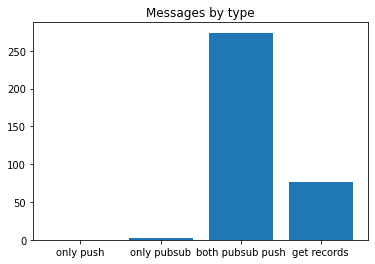

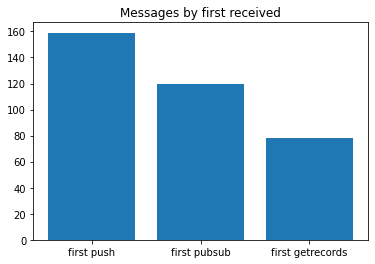

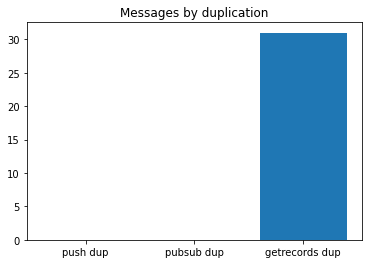

In [66]:
import matplotlib.pyplot as plt

def draw_hist(labels, values, title):
    plt.title(title)
    plt.bar(labels, values, align='center')
    plt.show()
    
draw_hist(["only push", "only pubsub", "both pubsub push", "get records"], [only_push, only_pubsub, both_pubsub_push, only_getrecords], 'Messages by type')
draw_hist(["first push", "first pubsub", "first getrecords"], [first_push, first_pubsub, first_getrecords], 'Messages by first received')
draw_hist(["push dup", "pubsub dup", "getrecords dup"], [push_dup, pubsub_dup, getrecords_dup], 'Messages by duplication')

(array([235.,  12.,  20.,   3.,   5.,   2.,   1.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   1.,   0.,   1.]),
 array([     0.  ,   2567.74,   5135.48,   7703.22,  10270.96,  12838.7 ,
         15406.44,  17974.18,  20541.92,  23109.66,  25677.4 ,  28245.14,
         30812.88,  33380.62,  35948.36,  38516.1 ,  41083.84,  43651.58,
         46219.32,  48787.06,  51354.8 ,  53922.54,  56490.28,  59058.02,
         61625.76,  64193.5 ,  66761.24,  69328.98,  71896.72,  74464.46,
         77032.2 ,  79599.94,  82167.68,  84735.42,  87303.16,  89870.9 ,
         92438.64,  95006.38,  97574.12, 100141.86, 102709.6 , 105277.34,
        107845.08, 110412.82, 112980.56, 115548.3 , 118116.04, 120683.78,
        123251.52, 125819.26, 128387.  ]),
 <BarContainer object o

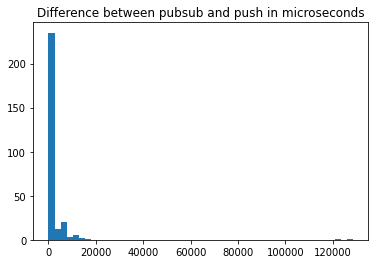

In [67]:
plt.title('Difference between pubsub and push in microseconds')
plt.hist(sorted_diff_ms, bins = 50)